## Method

Hit-and-run is a Markov chain Monte Carlo (MCMC)
sampling technique that iteratively generates
a sequence of points in a set by taking steps of
random length in randomly generated directions.
Hit-and-run can be applied to virtually any bounded

(1) Generate a random direction uniformly distributed over the surface of a unit hypersphere centered around the current point.

(2) Generate a random point (...)

(3)

[1] https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-1153-7_1145

## Distance to a linear constraint

In [1]:
using LazySets, Plots

In [2]:
using LinearAlgebra

# compute a unitary random direction in the given dimensions
function _unitary_random_direction(n)
    return normalize!(randn(n))
end

_unitary_random_direction (generic function with 1 method)

In [3]:
# distance we have to travel in direction dir,
# from point p, to reach a given hyperplane a^T x = b
function _distance(a, b, p, dir)
    α = dot(a, dir)
    LazySets.isapproxzero(α) && throw(ArgumentError("the direction is parallel to the hyperplane"))
    λ = (b - dot(a, p)) / α
    return λ
end

function _distance(H::Hyperplane, p, dir)
    return _distance(H.a, H.b, p, dir)
end

_distance (generic function with 2 methods)

In [4]:
p = [1, 1.]
dir = _unitary_random_direction(2)

2-element Array{Float64,1}:
 0.24990147139578237
 0.9682712711808726

In [5]:
H = Hyperplane([2.5, 1.0], 5.0)

Hyperplane{Float64,Array{Float64,1}}([2.5, 1.0], 5.0)

In [6]:
λ = _distance(H, p, dir)

0.9416048382107387

In [7]:
dot(H.a, dir)

1.5930249496703286

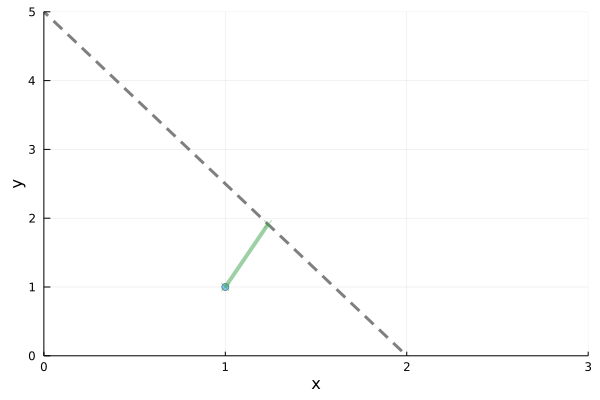

In [8]:
fig = plot(xlims=(0, 3), ylims=(0, 5), xlab="x", ylab="y")

plot!(fig, Singleton(p))
plot!(fig, H, lw=3.0, c=:black, style=:dash)
plot!(fig, LineSegment(p + zeros(2), p + λ*dir), marker=:x, lw=4.0)

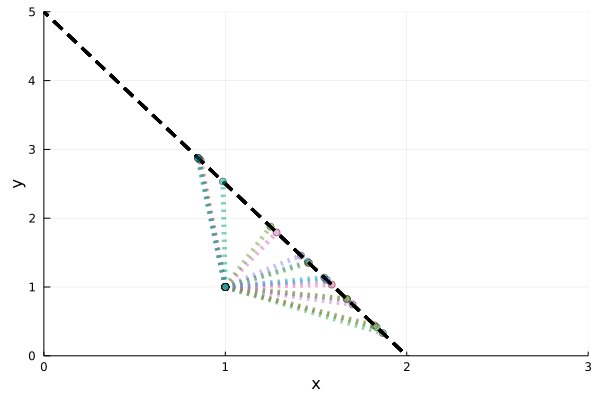

In [9]:
fig = plot(xlims=(0, 3), ylims=(0, 5), xlab="x", ylab="y")

for _ in 1:20
    dir = _unitary_random_direction(2)
    λ = _distance(H, p, dir)
    
    # keep short distances
    λ > 5 && continue

    plot!(fig, Singleton(p))
    plot!(fig, H, lw=3.0, c=:black, style=:dash)
    plot!(fig, LineSegment(p + zeros(2), p + λ*dir), style=:dot, lw=5.0)
end
fig

## Sampling step

In [56]:
function _sample!(D, X; thin=1)
    
    # initialization
    p = an_element(X)
    n = dim(X)
    clist = constraints_list(X)
    D[1] = p

    if thin == 1
        for i in 2:length(D)
            D[i] = hitandrun(clist, D[i-1])
        end

    else
        aux = similar(p)
        for i in 2:length(D)
            D[i] = similar(p)
            copy!(aux, D[i-1])
            for _ in 1:thin
                hitandrun!(D[i], clist, aux)
                copy!(aux, D[i])
            end
        end
    end
    return D
end

hitandrun(clist::Vector{<:HalfSpace}, p) = hitandrun!(similar(p), clist, p)

function hitandrun!(q, clist::Vector{HT}, p) where {N, VT, HT<:HalfSpace{N, VT}}

    n = dim(first(clist))
    dir = _unitary_random_direction(n)
    m = length(clist)
    λ = Vector{N}(undef, m)
    @inbounds for (i, c) in enumerate(clist)
        λ[i] = _distance(c.a, c.b, p, dir)
    end

    λ₊ = minimum(λ[λ .> 0])
    λ₋ = maximum(λ[λ .< 0])

    @assert (λ₊ > 0) && (λ₋ < 0)

    U = LazySets.DefaultUniform(λ₋, λ₊)
    μ = rand(U)

    q .= p + μ * dir
    return q
end

hitandrun! (generic function with 1 method)

In [74]:
D = Vector{Vector{Float64}}(undef, 1000)
X = rand(HPolygon)
@time _sample!(D, X, thin=20);

  0.020072 seconds (200.80 k allocations: 18.079 MiB)


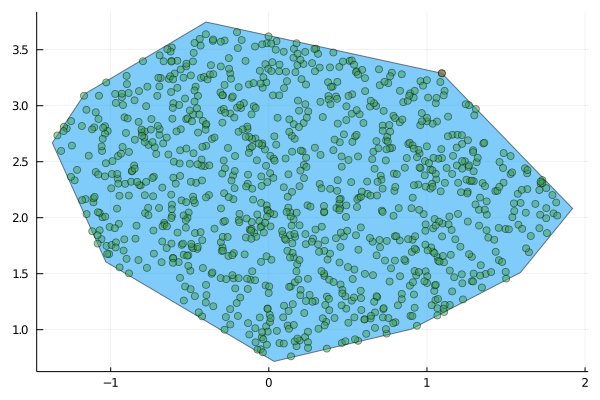

In [75]:
plot(X)
plot!(Singleton(an_element(X)), c=:red)
plot!(Singleton.(D))